In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
#Load and Preprocess Reviews Data
df_reviews = pd.read_csv('Reviews_dataset.csv', quotechar='"', escapechar='\\', skipinitialspace=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  #Convert to lowercase
  text = text.lower()

  # 2. Remove special characters and punctuation
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

  #Tokenize
  tokens = nltk.word_tokenize(text)

  #Remove stop words
  filtered_tokens = [token for token in tokens if token not in stop_words]

  #Lemmatize
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  #Join back into a string
  return ' '.join(lemmatized_tokens)

#Apply preprocessing
df_reviews['cleaned_review'] = df_reviews['review_text'].astype(str).apply(preprocess_text)
print(df_reviews['cleaned_review'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isijo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isijo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isijo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0      booked attending newmarket race easy efficient...
1      wonderful 4 star experience 3 star price great...
2      another nice stay hotel comfy room easy check ...
3      great hotel perfect location stayed one night ...
4      stayed ibis hotel 28 30 july would go downstai...
                             ...                        
422                                                  nan
423                                                  nan
424                                                  nan
425                                                  nan
426                                                  nan
Name: cleaned_review, Length: 427, dtype: object


In [3]:
#sentiment scoring
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    if not text or not isinstance(text, str) or not text.strip():
        return None
    try:
        vader_scores = analyzer.polarity_scores(text)
        sentiment_score = vader_scores['compound']
    except Exception as e:
        print(f"Error analyzing review: {text}. Exception: {e}")
        sentiment_score = None
    return sentiment_score

df_reviews['sentiment_score'] = df_reviews['cleaned_review'].apply(get_sentiment_scores)

#Convert 'date' column to datetime
df_reviews['date'] = pd.to_datetime(df_reviews['date'], format='%b-%y', errors='coerce')


print(df_reviews['sentiment_score'])

0      0.9850
1      0.9559
2      0.9337
3      0.9855
4      0.9169
        ...  
422    0.0000
423    0.0000
424    0.0000
425    0.0000
426    0.0000
Name: sentiment_score, Length: 427, dtype: float64


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\isijo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
#Aggregate sentiment scores by month
monthly_sentiment = df_reviews.groupby(pd.Grouper(key='date', freq='M')).agg(
    {'sentiment_score': 'mean', 'date': 'first'}).reset_index(drop=True)

print(monthly_sentiment)

    sentiment_score       date
0          0.511880 2023-05-01
1          0.824978 2023-06-01
2          0.918900 2023-07-01
3          0.937800 2023-08-01
4          0.870290 2023-09-01
5          0.832733 2023-10-01
6          0.956980 2023-11-01
7          0.964660 2023-12-01
8          0.814057 2024-01-01
9          0.968600 2024-02-01
10         0.923060 2024-03-01
11         0.618065 2024-04-01
12         0.524490 2024-05-01
13         0.654931 2024-06-01
14         0.659119 2024-07-01
15         0.593548 2024-08-01


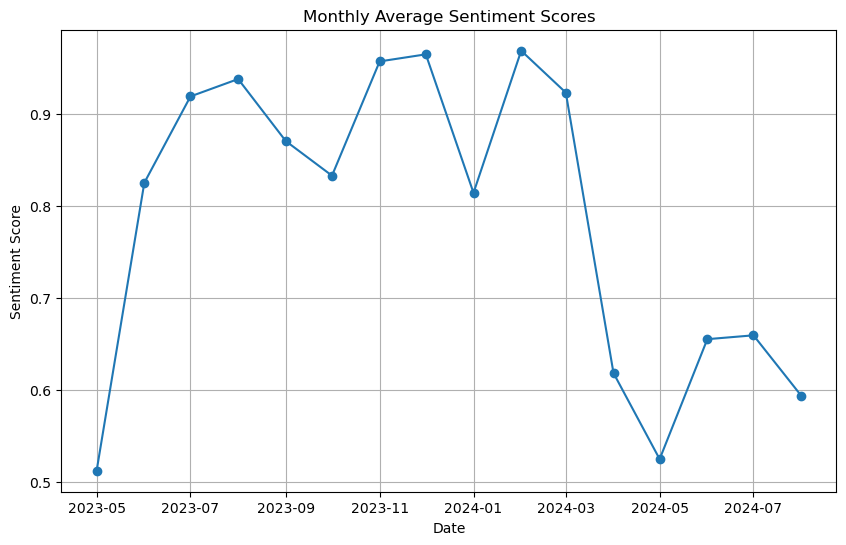

In [5]:
# Visualize Monthly Sentiment Scores
plt.figure(figsize=(10, 6))
plt.plot(monthly_sentiment['date'], monthly_sentiment['sentiment_score'], marker='o', linestyle='-')
plt.title('Monthly Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

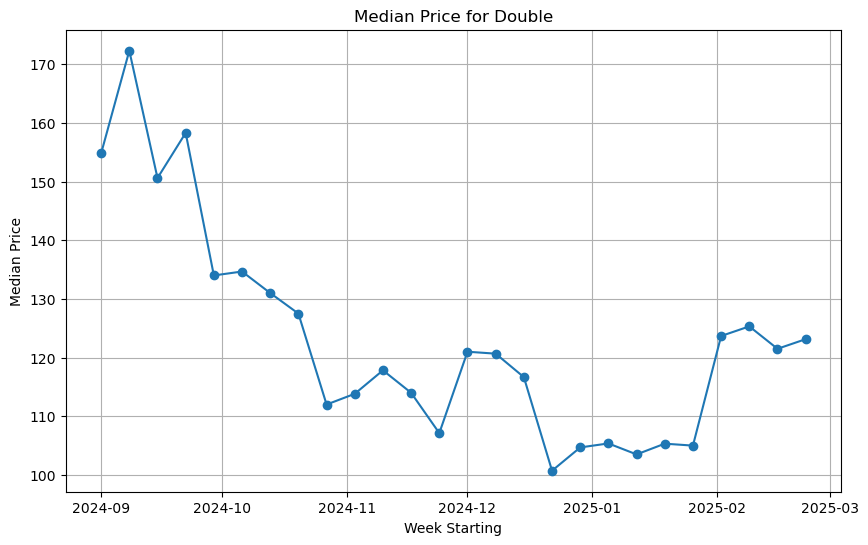

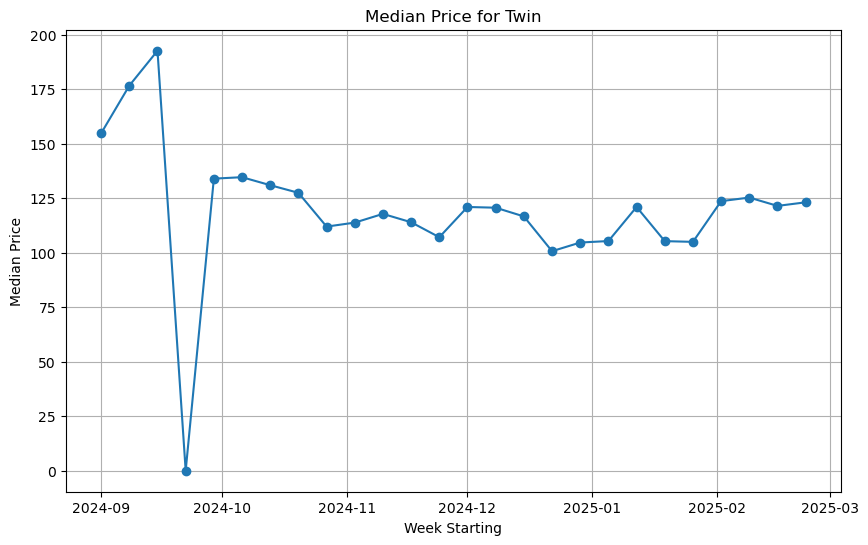

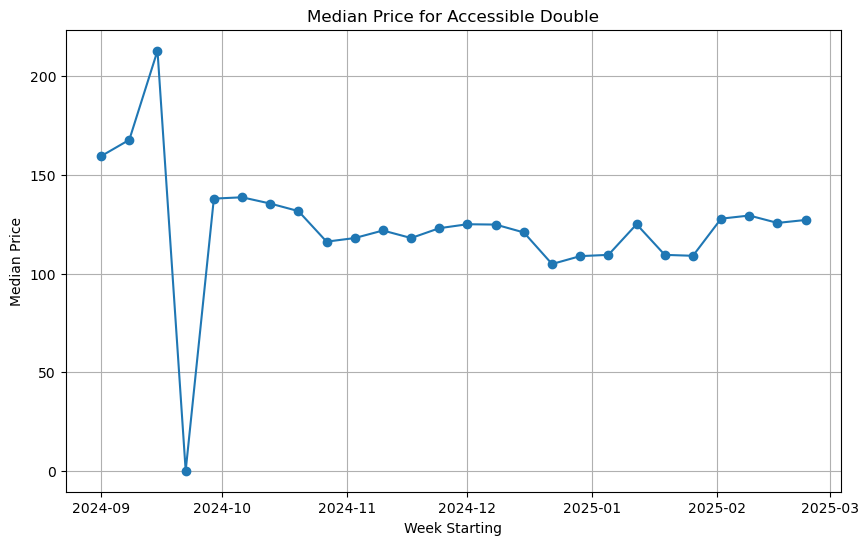

        date  median_price
0 2024-09-01    140.434667
1 2024-10-01    127.695833
2 2024-11-01    115.534167
3 2024-12-01    114.121333
4 2025-01-01    109.070000
5 2025-02-01    124.780833


In [6]:
#Pricing optimization
df_pricing = pd.read_csv('pricing_data.csv')

#Convert 'week_starting' to datetime and then extract the month
df_pricing['week_starting'] = pd.to_datetime(df_pricing['week_starting'])
df_pricing['date'] = df_pricing['week_starting'].dt.to_period('M')

#Visualize Median Prices by Room Type
for room_type in df_pricing['room_type'].unique():
    room_data = df_pricing[df_pricing['room_type'] == room_type]
    plt.figure(figsize=(10, 6))
    plt.plot(room_data['week_starting'], room_data['median_price'], marker='o', linestyle='-')
    plt.title(f'Median Price for {room_type}')
    plt.xlabel('Week Starting')
    plt.ylabel('Median Price')
    plt.grid(True)
    plt.show()

#Aggregate pricing data to monthly 
monthly_pricing = df_pricing.groupby('date').agg({'median_price':'mean'}).reset_index()

#Convert the 'month' column back to datetime for consistency
monthly_pricing['date'] = monthly_pricing['date'].dt.to_timestamp()

print(monthly_pricing)

In [7]:
#Extrapolate Sentiment Scores (using seasonal decomposition)

#Set 'date' as the index for seasonal decomposition
monthly_sentiment.set_index('date', inplace=True)

#Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_sentiment['sentiment_score'], model='additive', period=3)

#Extract the seasonal component
seasonal_component = decomposition.seasonal

#Get the last 12 months of seasonal indices
last_year_seasonal_indices = seasonal_component[-12:]

#Create a new DataFrame for the future period with seasonal indices
future_dates = pd.date_range(start='2024-09-01', end='2025-02-01', freq='MS')  # 'MS' for month start
extrapolated_sentiment = pd.DataFrame({'date': future_dates})
extrapolated_sentiment.set_index('date', inplace=True)

#Adjust the seasonal indices to cover the future period
extrapolated_sentiment['seasonal_index'] = last_year_seasonal_indices.values[:len(extrapolated_sentiment)]

#Get the last observed sentiment value
last_sentiment = monthly_sentiment['sentiment_score'].iloc[-1]

#Calculate seasonally adjusted extrapolated sentiment scores
extrapolated_sentiment['sentiment_score'] = last_sentiment + extrapolated_sentiment['seasonal_index']

#Reset the index to make 'date' a column again
extrapolated_sentiment.reset_index(inplace=True)

#Display the first few rows of the extrapolated sentiment data
print("Extrapolated Sentiment DataFrame:")
print(extrapolated_sentiment.head().to_markdown(index=False, numalign="left", stralign="left"))

Extrapolated Sentiment DataFrame:
| date                | seasonal_index   | sentiment_score   |
|:--------------------|:-----------------|:------------------|
| 2024-09-01 00:00:00 | 0.0394713        | 0.63302           |
| 2024-10-01 00:00:00 | -0.044982        | 0.548566          |
| 2024-11-01 00:00:00 | 0.00551076       | 0.599059          |
| 2024-12-01 00:00:00 | 0.0394713        | 0.63302           |
| 2025-01-01 00:00:00 | -0.044982        | 0.548566          |


In [9]:
#Merge Sentiment and Pricing Data (using the extrapolated sentiment)
merged_df = pd.merge(extrapolated_sentiment, monthly_pricing, on='date')

print(merged_df)

        date  seasonal_index  sentiment_score  median_price
0 2024-09-01        0.039471         0.633020    140.434667
1 2024-10-01       -0.044982         0.548566    127.695833
2 2024-11-01        0.005511         0.599059    115.534167
3 2024-12-01        0.039471         0.633020    114.121333
4 2025-01-01       -0.044982         0.548566    109.070000
5 2025-02-01        0.005511         0.599059    124.780833


In [10]:
#correlation analysis
correlation = merged_df['sentiment_score'].corr(merged_df['median_price'])
print("Correlation between sentiment and price:", correlation)

Correlation between sentiment and price: 0.3328207279180312


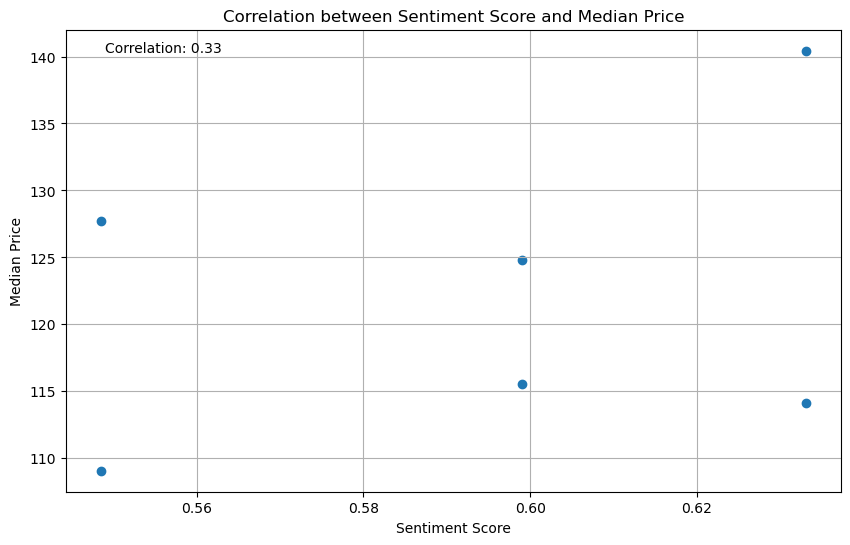

In [11]:
#visualize correlation with scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['sentiment_score'], merged_df['median_price'])
plt.title('Correlation between Sentiment Score and Median Price')
plt.xlabel('Sentiment Score')
plt.ylabel('Median Price')
plt.grid(True)

# Add the correlation coefficient to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

plt.show()

In [13]:
#Model development and evaluation
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

# Split data into training and testing sets (80% train, 20% test)
X = merged_df[['sentiment_score']] 
y = merged_df['median_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

In [14]:
# Perform 3-fold cross-validation on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=3,  scoring='neg_mean_squared_error')
# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [ -86.45844393 -402.4888524  -182.07222405]
Mean CV score: -223.67317346199613


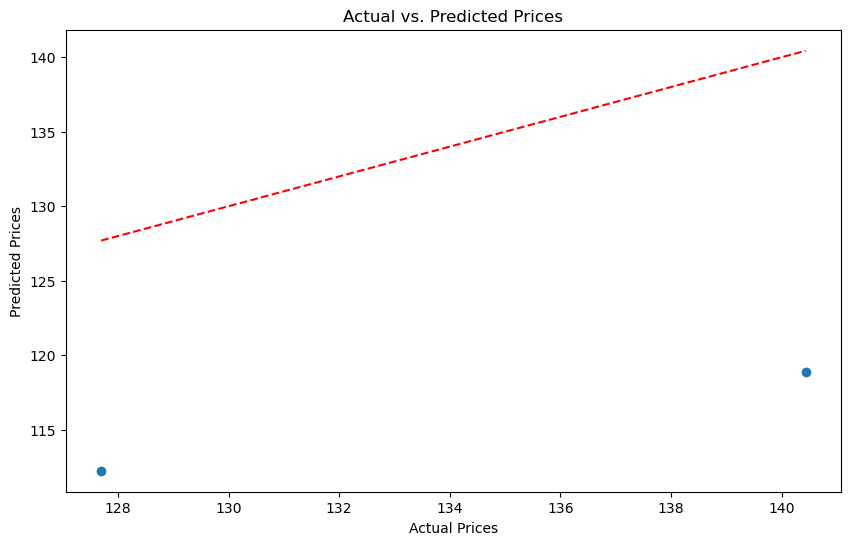

In [15]:
#Train Model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Visualize actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")

#diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')

plt.show()

In [16]:
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 352.10192685903894
R-squared: -7.678987878588309
